# HW5
### Hyunwoo Roh

### Question 1-(a) 
Plot a histogram of percentages of the income.txt data with 30 bins. 

In [92]:
import numpy as np
import scipy.stats as sts
import math
import matplotlib.pyplot as plt
import scipy.integrate as intgr
import scipy.optimize as opt
import numpy.linalg as lin

income= np.loadtxt('data/incomes.txt', delimiter=',', unpack=True)

<IPython.core.display.Javascript object>


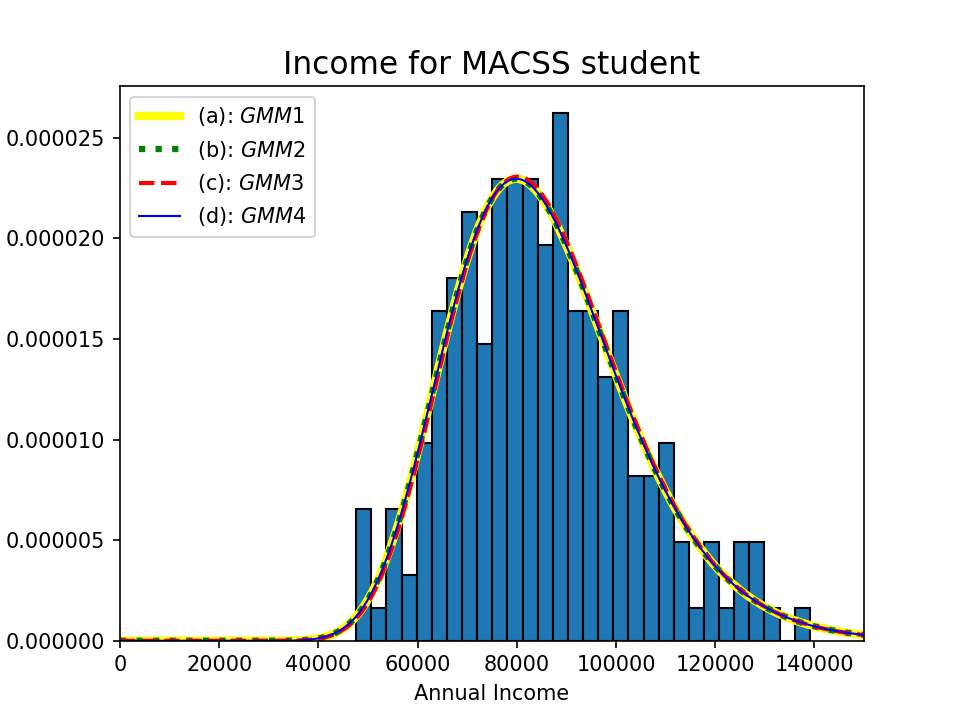

(0, 150000)

In [115]:
%matplotlib notebook
plt.hist(income, 30, edgecolor='black',normed=True)
plt.title('Income for MACSS student', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percentages')
plt.xlim([0,150000])

### Question 1-(b)
Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix W . 
Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.
<br>$\Rightarrow$ To do that first define all the necessary functions, parameters, and moment conditions

In [94]:
# This chunk of codes are from the lecture notes.

def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

def data_moments(xvals):
   
    mean_data = xvals.mean()
    std_data = xvals.std() # this part is different from lec note
    
    return mean_data, std_data

def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):

    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Let's start with the identity matrix as our estimate for the optimal weighting matrix $W = I$.

In [95]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) # Define W as identity matrix
gmm_args = (income, 0.0, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results.x

mu_GMM1= 11.33359961340108  sig_GMM1= 0.21325529509280874


array([11.33359961,  0.2132553 ])

In [116]:
x = np.linspace(0.001, 150000.0, 1000)
plt.plot(x, trunc_lognorm_pdf(x, mu_GMM1, sig_GMM1, 0.0, 150000), 
         linewidth = 4, color = 'yellow',label='(a): $GMM1$')
plt.legend(loc='upper left')
plt.show()

In [97]:
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print('Value of GMM criterion function= ', results.fun[0])
print('Error= ', err_vec(income, mu_GMM1, sig_GMM1,0,150000,False).reshape(2,))
print('Data mean, standard deviation = ', data_moments(income))
print('Model mean, standard deviation = ', model_moments(mu_GMM1, sig_GMM1,0,150000))

mu_GMM1= 11.33359961340108  sig_GMM1= 0.21325529509280874
Value of GMM criterion function=  [6.39927099e-16]
Error=  [ 5.30380584e-09 -2.47345253e-08]
Data mean, standard deviation =  (85276.82360625811, 17992.542128046523)
Model mean, standard deviation =  (85276.82405854983, 17992.541683009535)


### Question 1-(c)
Perform the two step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix $\Omega_2step$, which you then use to get the two-step estimator for the optimal weighting matrix $W_2step$. Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part(b). Report and compare your two data moments against your two model moments at the esitmated parameter values. 

In [98]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
  
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat

In [99]:
err_mat = get_Err_mat2(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
#print(err_mat)
print("W_hat:","\n",W_hat)
VCV2 = np.dot(err_mat, err_mat.T) / income.shape[0]
#VCV2 = (1 / income.shape[0]) * (err_mat @ err_mat.T)
print("VCV2:","\n",VCV2)
W_hat2 = lin.inv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print("W_hat2:","\n",W_hat2)

W_hat: 
 [[1. 0.]
 [0. 1.]]
VCV2: 
 [[4.45167060e-02 1.68385288e+03]
 [1.68385288e+03 9.54184437e+08]]
W_hat2: 
 [[ 2.40701668e+01 -4.24767141e-05]
 [-4.24767141e-05  1.12297423e-09]]


In [100]:
# Re-estimate the GMM estimator using the optimal two-step weighting matrix.
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (income, 0.0, 150000.0, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print('Error2= ', err_vec(income, mu_GMM2, sig_GMM2,0,150000,False).reshape(2,))
print('Data mean, standard deviation = ', data_moments(income))
print('Model mean, standard deviation = ', model_moments(mu_GMM2, sig_GMM2,0,150000))

mu_GMM2= 11.333599603618694  sig_GMM2= 0.2132552944762079
mu_GMM1= 11.33359961340108  sig_GMM1= 0.21325529509280874
Error2=  [-4.21945751e-09 -3.45683491e-08]
Data mean, standard deviation =  (85276.82360625811, 17992.542128046523)
Model mean, standard deviation =  (85276.82324643618, 17992.541506074045)


GMM1 and GMM2 are very slightly different!

In [117]:
x = np.linspace(0.001, 150000.0, 1000)
plt.plot(x, trunc_lognorm_pdf(x, mu_GMM2, sig_GMM2, 0.0, 150000), 
         linewidth = 3, color = 'green',label='(b): $GMM2$',linestyle=':')
plt.legend(loc='upper left')
plt.show()

### Question 1-(d)

(d) Now estimate the lognormal PDF to ﬁt the data by GMM using diﬀerent moments. Use percent of individuals who earn less than USD75,000, percent of individuals who earn between USD75,000 and USD100,000, and percent of individuals who earn more than USD100,000 as your three moments. Use the identity matrix as your estimator for the optimal weighting matrix. Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

In [102]:
def data_moments3(xvals):

    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals > 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):

    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):

    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion3(params, *args):

    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [103]:
#Estimate the lognormal PDF to fit the data by GMM using different moments
W_hat3 = np.eye(3)
gmm_args = (income, 0.0, 150000.0, W_hat1_3)

results3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM3, sig_GMM3 = results3.x
mu_GMM3, sig_GMM3

(11.33670517992345, 0.21151351610769806)

In [104]:
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)
print('Value of GMM criterion function= ', results3.fun[0])
print('Error= ', err_vec3(income, mu_GMM3, sig_GMM3,0,150000,False).reshape(3,))
print('Data moments = ', data_moments3(income))
print('Model moments = ', model_moments3(mu_GMM3, sig_GMM3,0,150000))

mu_GMM3= 11.33670517992345  sig_GMM3= 0.21151351610769806
Value of GMM criterion function=  [2.44369935e-15]
Error=  [ 1.13768173e-08  1.18261376e-08 -4.66305677e-08]
Data moments =  (0.3, 0.5, 0.2)
Model moments =  (0.30000000341304517, 0.5000000059130688, 0.19999999067388646)


We can see that three moments are very similar between data and model.

In [118]:
x = np.linspace(0.001, 150000.0, 1000)
plt.plot(x, trunc_lognorm_pdf(x, mu_GMM3, sig_GMM3, 0.0, 150000), 
         linewidth = 2, color = 'red',label='(c): $GMM3$',linestyle='--')
plt.legend(loc='upper left')
plt.show()

### Question 1-(e)

In [106]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded R = 3.
    --------------------------------------------------------------------
    '''
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [107]:
err_mat3 = get_Err_mat3(income, mu_GMM3, sig_GMM3, 0.0, 150000.0, False)
#print(err_mat)
print("W_hat:","\n",W_hat3)
VCV2_3 = np.dot(err_mat3, err_mat3.T) / income.shape[0]
#VCV2 = (1 / income.shape[0]) * (err_mat @ err_mat.T)
print("VCV2_3:","\n",VCV2_3)
W_hat2_3 = lin.inv(VCV2_3)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print("W_hat2_3:","\n",W_hat2_3)

W_hat: 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
VCV2_3: 
 [[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
W_hat2_3: 
 [[-1.82608322e+14 -3.04347204e+14 -1.21738874e+14]
 [-3.04347204e+14 -5.07245340e+14 -2.02898124e+14]
 [-1.21738874e+14 -2.02898124e+14 -8.11592450e+13]]


In [108]:
# Re-estimate the GMM estimator using the optimal two-step weighting matrix.

params_init = np.array([mu_GMM3, sig_GMM3])
gmm_args = (income, 0.0, 150000.0, W_hat2_3)
results4 = opt.minimize(criterion3, params_init, args=(gmm_args),tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results2.x
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM4, sig_GMM4, 0.0, 150000.0)
print('mu_GMM2=', mu_GMM4, ' sig_GMM2=', sig_GMM4)
print('mu_GMM1=', mu_GMM3, ' sig_GMM1=', sig_GMM3)
print('Value of GMM criterion function= ', results3.fun[0])
print('Error= ', err_vec3(income, mu_GMM4, sig_GMM4,0,150000,False).reshape(3,))
print('Data moments = ', data_moments3(income))
print('Model moments = ', model_moments3(mu_GMM4, sig_GMM4,0,150000))

mu_GMM2= 11.333599603618694  sig_GMM2= 0.2132552944762079
mu_GMM1= 11.33670517992345  sig_GMM1= 0.21151351610769806
Value of GMM criterion function=  [2.44369935e-15]
Error=  [ 0.02208422 -0.00875997 -0.01122641]
Data moments =  (0.3, 0.5, 0.2)
Model moments =  (0.306625264757934, 0.49562001625959295, 0.19775471898247324)


Model moments are still close to Data moments, however it is less close than the one before.

In [119]:
x = np.linspace(0.001, 150000.0, 1000)
plt.plot(x, trunc_lognorm_pdf(x, mu_GMM4, sig_GMM4, 0.0, 150000), 
         linewidth = 1, color = 'blue',label='(d): $GMM4$',linestyle='-')
plt.legend(loc='upper left')
plt.show()

### Question 1-(f)
Compare the 4 gmm estimators

They are all very similar. However, we can say that between the two that use same moment condition **(c) is better than (b) in that  and (d) is better than (e)** in terms of value of GMM criterion function as well as the degree of similary to the true model moments. Between the two moment condition and three moment condition, since the (d)'s mu is bit different from all others, (c) is the better than (d), which concludes that (c) is the best among four.

# Question 2 Linear regression and GMM

(a) Estimate the parameters of the model by GMM by solving the minimization problem of the GMM criterion function. Use the identity matrix as the estimator for the optimal weighting matrix. Treat each of the 200 values of the variable sick as your data moments. Treat the predicted or expected sick values from your model as your model moments. 

In [110]:
data = np.loadtxt("data\sick.txt", skiprows = 1,delimiter  = ',')
sick = data[:,0]
age = data[:,1]
children = data[:,2]
temp_winter = data[:,3]
data.shape

(200, 4)

In [111]:
# error function of the moemnts

def err_vec(sick,b0,b1,b2,b3):
    
    # Model Moments as predicted sick values
    yhat=b0 + b1*age + b2*children + b3*temp_winter
    
    # Data Moments 200 values of variable sick
    y=sick
    
    err_vec = yhat - y # simple difference
    
    return err_vec

def criterion(params, *args):
    
    b0,b1,b2,b3 = params
    data, W = args
    err = err_vec(data,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val

In [112]:
b0, b1, b2, b3 = 1, 1, 1, 1
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(200)
gmm_args = (sick, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
b0, b1, b2, b3 = results.x

In [113]:
print("betas are", results.x)

betas are [ 0.25164474  0.01293345  0.40050118 -0.0099917 ]


In [114]:
print('GMM criterion function is', results.fun)

GMM criterion function is 0.0018212898171902307
